<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1lfulldataset_splitting_nnmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
Split Xq1 and yq1 into 80-20 train validation split.
save them as separate. 

looking at
1. log reg
2. decision tree
3. skipping svm and knn.
4. random forest
5. adaboost
6. xgboost
7. neural net dense in keras

compare best performances for each type of model. 

In [1]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [ ]:
!pip install mxnet-cu80
import mxnet as mx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 372.1 MB 25 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


OSError: ignored

In [ ]:
a = mx.nd.ones((2, 3), mx.gpu())
b = a * 2 + 1
b.asnumpy()

Getting yq1 and Xq1:

Getting yq1 from datadfq1

In [4]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Getting saved yq1 from drive:

Gatting Xq1 from drive

In [5]:
Xq1 = decompress_pickle(path_name+"Xq1all.pbz2") 
yq1 = decompress_pickle(path_name+"yq1all.pbz2") 

In [6]:
type(Xq1), type(yq1)

(scipy.sparse.coo.coo_matrix, pandas.core.series.Series)

In [7]:
from scipy.sparse import coo_matrix

In [8]:
Xq1.shape, yq1.shape

((7313354, 2233), (7313354,))

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [9]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(Xq1,yq1,test_size=0.2,random_state=5)

In [10]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((5850683, 2233), (1462671, 2233), (5850683,), (1462671,))

Fraction of ones in the train and validation sets

In [11]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.1611603294863181, 0.16108748994134703)

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [12]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train)
Xq1_mm_train = mm_scaler.transform(Xq1_train)
Xq1_mm_valid = mm_scaler.transform(Xq1_valid)


### Keras Neural Net
 


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Converting Xq1 to sparse tensorflow tensor

In [17]:
Xq1_mm_train = Xq1_mm_train.tocoo()
Xq1_mm_valid = Xq1_mm_valid.tocoo()

In [18]:
indices_train = [[u,v] for u,v in zip(Xq1_mm_train.row,Xq1_mm_train.col)]
indices_valid = [[u,v] for u,v in zip(Xq1_mm_valid.row,Xq1_mm_valid.col)]

In [19]:
values_train = Xq1_mm_train.data
values_valid = Xq1_mm_valid.data

In [20]:
dense_shape_train = [Xq1_mm_train.shape[0],Xq1_mm_train.shape[1]]
dense_shape_valid = [Xq1_mm_valid.shape[0],Xq1_mm_valid.shape[1]]

In [21]:
Xq1_mm_train_tf = tf.sparse.SparseTensor(indices=indices_train,
                      values=values_train,
                      dense_shape=dense_shape_train)

In [22]:
Xq1_mm_valid_tf = tf.sparse.SparseTensor(indices=indices_valid,
                      values=values_valid,
                      dense_shape=dense_shape_valid)

In [23]:
compressed_pickle(path_name+'sparse_tensor_Xq1_mm_train_tf',Xq1_mm_train_tf)
compressed_pickle(path_name+'sparse_tensor_Xq1_mm_valid_tf',Xq1_mm_valid_tf)

In [24]:
yq1_train_np = np.array(yq1_train)
yq1_valid_np = np.array(yq1_valid)

In [28]:
compressed_pickle(path_name+'yq1_train_nparray',yq1_train_np)
compressed_pickle(path_name+'yq1_valid_nparray',yq1_train_np)

In [25]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(2233, activation="relu"))
model.add(layers.Dense(2233, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(16, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [26]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
)

I've learned that increasing batch size to optimize run time is effective. 

In [30]:
history = model.fit(Xq1_mm_train_tf, yq1_train_np, epochs=5, verbose=1, batch_size=40000,validation_data = (Xq1_mm_valid,yq1_valid_np))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2233), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


147/147 [==============================] - 90s 495ms/step - loss: 0.4310 - binary_accuracy: 0.8342 - val_loss: 0.4168 - val_binary_accuracy: 0.8389
Epoch 2/5
147/147 [==============================] - 86s 491ms/step - loss: 0.4158 - binary_accuracy: 0.8396 - val_loss: 0.4155 - val_binary_accuracy: 0.8398
Epoch 3/5
147/147 [==============================] - 86s 494ms/step - loss: 0.4148 - binary_accuracy: 0.8400 - val_loss: 0.4150 - val_binary_accuracy: 0.8400
Epoch 4/5
147/147 [==============================] - 86s 494ms/step - loss: 0.4143 - binary_accuracy: 0.8400 - val_loss: 0.4148 - val_binary_accuracy: 0.8401
Epoch 5/5
147/147 [==============================] - 86s 495ms/step - loss: 0.4139 - binary_accuracy: 0.8401 - val_loss: 0.4150 - val_binary_accuracy: 0.8400


In [31]:
compressed_pickle(path_name+"history",history)

INFO:tensorflow:Assets written to: ram://d6678e4a-2dd2-4f01-bdb1-e6637de3852c/assets


In [39]:
yq1_valid_preds = model.predict(Xq1_mm_valid,batch_size=40000,verbose=2)

37/37 - 6s - 6s/epoch - 173ms/step


array([[0.21313871],
       [0.10361329],
       [0.09185846],
       ...,
       [0.0820886 ],
       [0.1581438 ],
       [0.12379754]], dtype=float32)

In [36]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, roc_auc_score

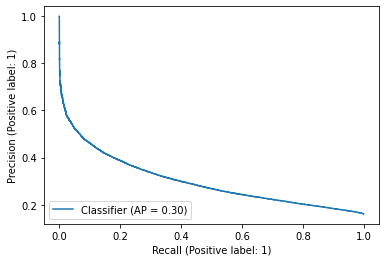

In [41]:
PrecisionRecallDisplay.from_predictions(yq1_valid_np,yq1_valid_preds)

Performance is equivalent to l1 penalty logistic regression without any class weight changes. 